# NHANES Diabetes Analysis (2017–2018)

This notebook explores and prepares data from the **National Health and Nutrition Examination Survey (NHANES)** for predictive modeling of **Type 2 Diabetes** risk, using the biomarker **HbA1c (glycohemoglobin)** as the target.

### Project Goal
Build a clean, imputation-ready dataset to support modeling of diabetes diagnosis based on:
- Demographic factors (age, sex, race, income)
- Anthropometric measures (BMI, waist, hip, leg length)
- Survey responses (education, citizenship, marital status)

### Data Source
- **NHANES 2017–2018 Public Data**
- Components used:
  - DEMO_J (Demographics)
  - BMX_J (Body Measures)
  - GHB_J (HbA1c Lab Results)
  - DIQ_J (Diabetes Questionnaire)

### 🔧 Notebook Workflow
1. Download and merge raw NHANES CSVs
2. Clean and reformat corrupted values
3. Analyze missingness and data quality
4. Encode categorical variables
5. Impute missing data using `IterativeImputer`
6. Visualize relationships with HbA1c and create a diagnostic flag

### Target Variable
`LBXGH`: Glycohemoglobin (HbA1c)
- A value of **6.5% or greater** is used to define diabetes diagnosis.

---

## Libraries

In [176]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
import statsmodels.api as sm


import warnings
warnings.filterwarnings("ignore")

## Data Cleaning

This section prepares the NHANES dataset for analysis. It includes:
- Loading and inspecting the dataset.
- Removing empty columns.
- Exploring missing data.
- Replacing NHANES-specific codes (e.g., 7, 77, 99) with `NaN`.


In [177]:
# Load dataset
file_path = "./datasets/nhanes_hba1c_merged.csv"
df = pd.read_csv(file_path)

In [178]:
# Initial Data Processing

# Checking Target variable availability
print("Row Number:", df.shape[0])
print("Rows with HbA1c (LBXGH):", df["LBXGH"].notna().sum())
print("Rows with age + HbA1c:", df[["RIDAGEYR", "LBXGH"]].dropna().shape[0])

# Looking for Duplicate Entries
duplicate_seqn = df["SEQN"].duplicated().sum()
print("Duplicate SEQN entries:", duplicate_seqn)

# Dropping Empty Columns
empty_cols = [col for col in df.columns if df[col].isnull().all()]
print(f"Empty Columns: {empty_cols}")
df = df.drop(empty_cols, axis=1)

# Summary of Missing Data
nan_count = df.isnull().sum()
na_percentage = (nan_count / 9254)*100
na_high = (na_percentage > 40).sum()
print(f"Number of Columns with greater than 40% of values being NA: {na_high}")
df = df.loc[:, df.isna().mean() < 0.4]

missing_lbxgh = df['LBXGH'].isna().sum()
print(f"Rows with missing LBXGH (HbA1c): {missing_lbxgh}")
df = df.dropna(subset=['LBXGH'])

# Columns deemed irrelevant to overral goals
irrelevant_cols = [
    'SDDSRVYR', 'RIDSTATR',
    'SIALANG', 'SIAPROXY', 'SIAINTRP',
    'FIALANG', 'FIAPROXY', 'FIAINTRP',
    'MIALANG', 'MIAPROXY', 'MIAINTRP',
    'DMDHRGND', 'DMDHRAGZ', 'DMDHREDZ', 'DMDHRMAZ',
    'SDMVPSU', 'SDMVSTRA',
    'BMDSTATS', 'DIQ010', 'DIQ160', 'DIQ170'	
    ,'DIQ172'	
    ,'DIQ180', 'DIQ050', 'WTINT2YR', 'WTMEC2YR', 'SDMVPSU', 'SDMVSTRA', "RIDEXMON"
]

print(f"Irrelevant Col Count: {len(irrelevant_cols)}")
df = df.drop(irrelevant_cols, axis=1)

df_o = df

print(f"Final Data Shape: {df.shape}")

Row Number: 9254
Rows with HbA1c (LBXGH): 6045
Rows with age + HbA1c: 6045
Duplicate SEQN entries: 0
Empty Columns: ['BMIHEAD']
Number of Columns with greater than 40% of values being NA: 65
Rows with missing LBXGH (HbA1c): 3209
Irrelevant Col Count: 29
Final Data Shape: (6045, 27)


### Setting Variable Types

In [179]:
numeric_vars = [
    "RIDAGEYR",     # Age
    "INDFMPIR",     # Income to poverty ratio
    "BMXWT",        # Weight
    "BMXHT",        # Height
    "BMXBMI",       # BMI
    "BMXLEG",       # Leg length
    "BMXARML",      # Arm length
    "BMXARMC",      # Arm circumference
    "BMXWAIST",     # Waist circumference
    "BMXHIP",       # Hip circumference
    "LBXGH"         # HbA1c (target)
]

categorical_vars = [
    "RIAGENDR",     # Gender
    "RIDRETH1",     # Race/ethnicity (5-level)
    "RIDRETH3",     # Race/ethnicity (6-level)
    "DMQMILIZ",     # Military service
    "DMDBORN4",     # Country of birth
    "DMDCITZN",     # Citizenship status
    "DMDEDUC2",     # Education level
    "DMDMARTL",     # Marital status
    "DMDHHSIZ",     # Household size
    "DMDFMSIZ",     # Family size
    "DMDHHSZA",     # Children 0–5
    "DMDHHSZB",     # Children 6–17
    "DMDHHSZE",     # Adults 60+
    "INDHHIN2",     # Household income
    "INDFMIN2"     # Family income
]

### NA Analysis

#### Codebook-Driven Missingness

Certain categorical variables use codes like `7`, `9`, `77`, and `99` to indicate missing values.
We'll convert these to `np.nan` for consistency.


In [180]:
df["DMQMILIZ"] = df["DMQMILIZ"].replace({7: np.nan, 9: np.nan})
df["DMDBORN4"] = df["DMDBORN4"].replace({77: np.nan, 99: np.nan})
df["DMDCITZN"] = df["DMDCITZN"].replace({7: np.nan, 9: np.nan})
df["DMDEDUC2"] = df["DMDEDUC2"].replace({7: np.nan, 9: np.nan})
df["DMDMARTL"] = df["DMDMARTL"].replace({77: np.nan})

# Replace numeric NA codes with np.nan based on NHANES documentation
na_mappings = {
    "DMDHHSIZ": {99: np.nan},       # If present — though household size usually caps at 7
    "DMDFMSIZ": {99: np.nan},
    "DMDHHSZA": {99: np.nan},
    "DMDHHSZB": {99: np.nan},
    "DMDHHSZE": {99: np.nan},
    "INDHHIN2": {77: np.nan, 99: np.nan},
    "INDFMIN2": {77: np.nan, 99: np.nan},
    "INDFMPIR": {9.99: np.nan}  # 9.99 = missing income-to-poverty ratio in some NHANES waves
}

for col, mapping in na_mappings.items():
    if col in df.columns:
        df[col] = df[col].replace(mapping)


In [181]:
# NA percentage by Column
na_summary = df.isna().mean().sort_values(ascending=False)
print(na_summary)

DMDEDUC2    0.171712
DMDMARTL    0.170720
INDFMPIR    0.126716
DMQMILIZ    0.107361
INDHHIN2    0.089165
INDFMIN2    0.087014
BMXLEG      0.053102
BMXWAIST    0.049297
BMXHIP      0.047146
BMXARMC     0.039371
BMXARML     0.039041
BMXBMI      0.015550
BMXHT       0.014227
BMXWT       0.014061
DMDCITZN    0.003639
DMDBORN4    0.000496
SEQN        0.000000
DMDHHSZB    0.000000
DMDHHSZE    0.000000
RIAGENDR    0.000000
DMDHHSZA    0.000000
DMDFMSIZ    0.000000
DMDHHSIZ    0.000000
RIDRETH3    0.000000
RIDRETH1    0.000000
RIDAGEYR    0.000000
LBXGH       0.000000
dtype: float64


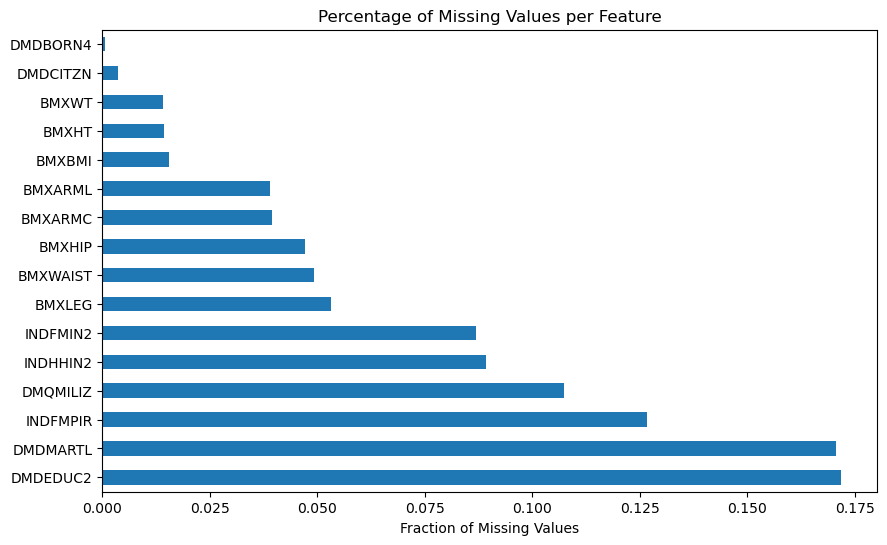

In [182]:
# Plot missing value fractions

na_counts = df.isna().sum().sort_values(ascending=False)
na_counts = na_counts[na_counts > 0].apply(lambda x: x/df.shape[0])

na_counts.plot(kind='barh', figsize=(10, 6))
plt.title("Percentage of Missing Values per Feature")
plt.xlabel("Fraction of Missing Values")
plt.show()

## Numerical Feature Analysis

This section explores:
- **Correlations** between numeric features to identify potential multicollinearity.
- **Distributions** of each numeric variable to understand their spread and shape.


#### Correlation Matrix

We compute the Pearson correlation between all numeric features.
High correlation (absolute value > 0.8) suggests potential multicollinearity and candidates for dimensionality reduction.

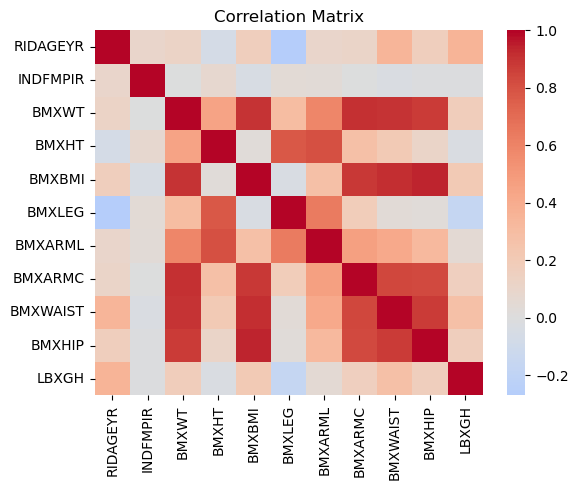

In [183]:
# Running Correlation Analysis on Numerical Features

df_corr = df[numeric_vars].drop(columns=["SEQN"], errors="ignore")

corr_matrix = df_corr.corr(method='pearson')
#print((corr_matrix > 0.9).sum())

# Visualize
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

### Distribution Analysis

Below are histograms and normal curve fits for each numeric variable.
These help detect skewness, multimodality, or outliers.
- If a variable deviates strongly from normality, it may benefit from transformations (e.g., log, sqrt).
- Visual checks also help flag data quality issues (e.g., digit preference, truncation).


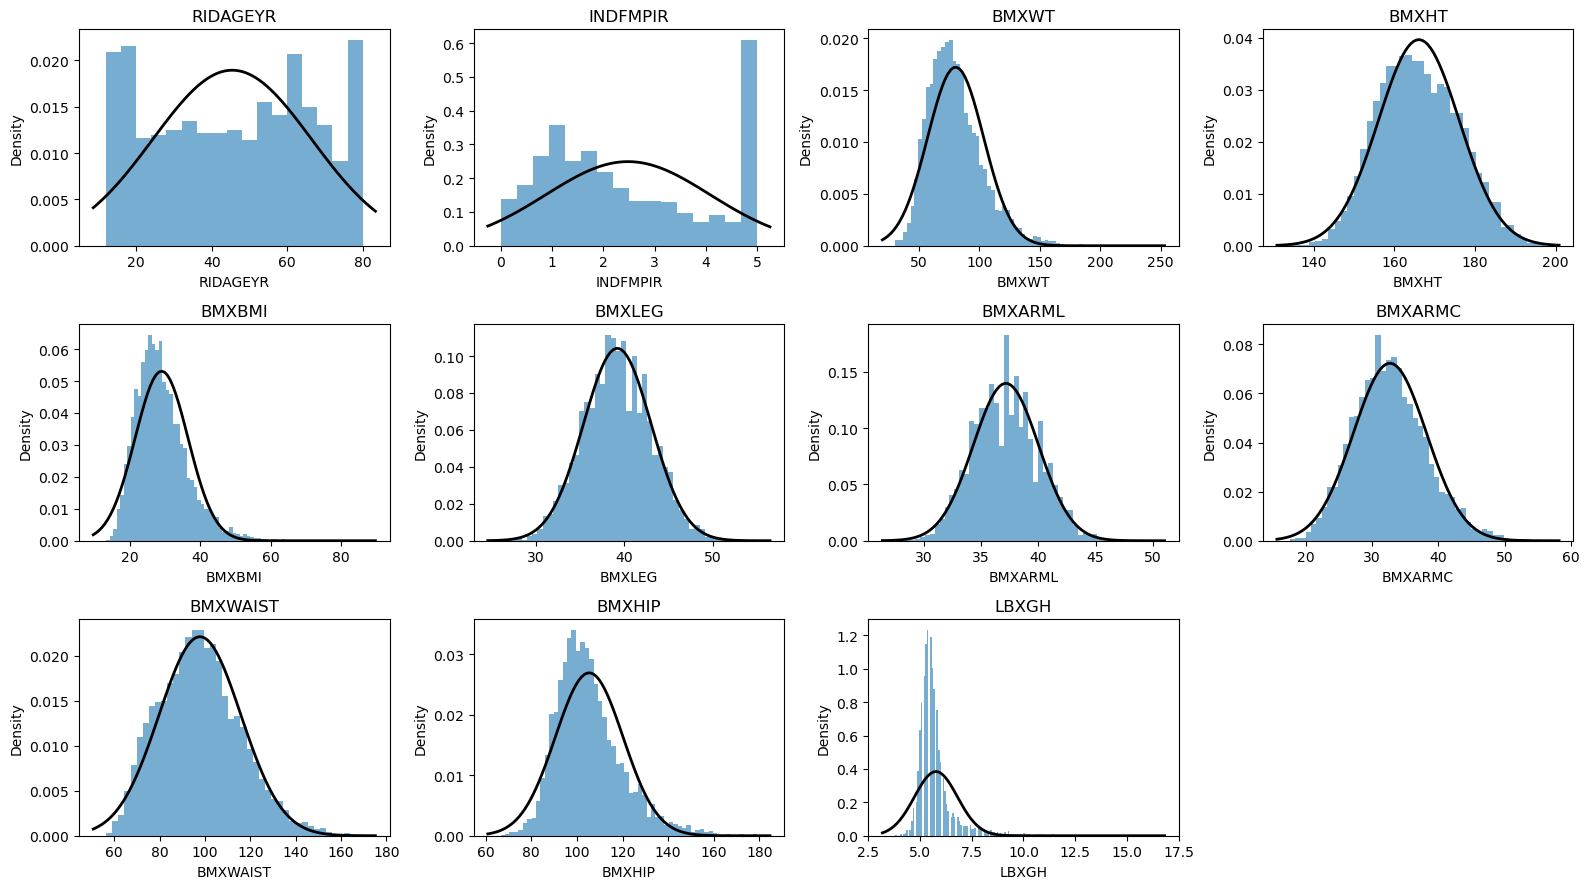

In [184]:
# Plotting Distributions of Numerical Vars

# Define grid size
n_cols = 4  # Number of histograms per row
n_rows = math.ceil(len(df[numeric_vars].columns) / n_cols)


# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()


# Plot histograms
for i, col in enumerate(df[numeric_vars].columns):
    data = df[numeric_vars][col].dropna()
    
    # Histogram
    axes[i].hist(data, bins='auto', density=True, alpha=0.6)
    
    # Fit normal distribution
    mu, sigma = norm.fit(data)
    
    # Overlay normal PDF
    xmin, xmax = axes[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, sigma)
    axes[i].plot(x, p, 'k', linewidth=2)
    
    # Titles and labels
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Density")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Categorical Feature Analysis

This section examines the structure and distribution of categorical variables.
We aim to:
- Understand cardinality (number of unique values).
- Visualize distributions to detect class imbalances.
- Identify variables with sparse or dominant categories that could impact modeling.

In [185]:
# Count number of unique values per categorical variable
df[categorical_vars].nunique()

RIAGENDR     2
RIDRETH1     5
RIDRETH3     6
DMQMILIZ     2
DMDBORN4     2
DMDCITZN     2
DMDEDUC2     5
DMDMARTL     6
DMDHHSIZ     7
DMDFMSIZ     7
DMDHHSZA     4
DMDHHSZB     4
DMDHHSZE     4
INDHHIN2    14
INDFMIN2    14
dtype: int64

### Class Balance Check

Severe class imbalance can hurt predictive models.
Below, we print the percentage share of each category to identify imbalanced variables.


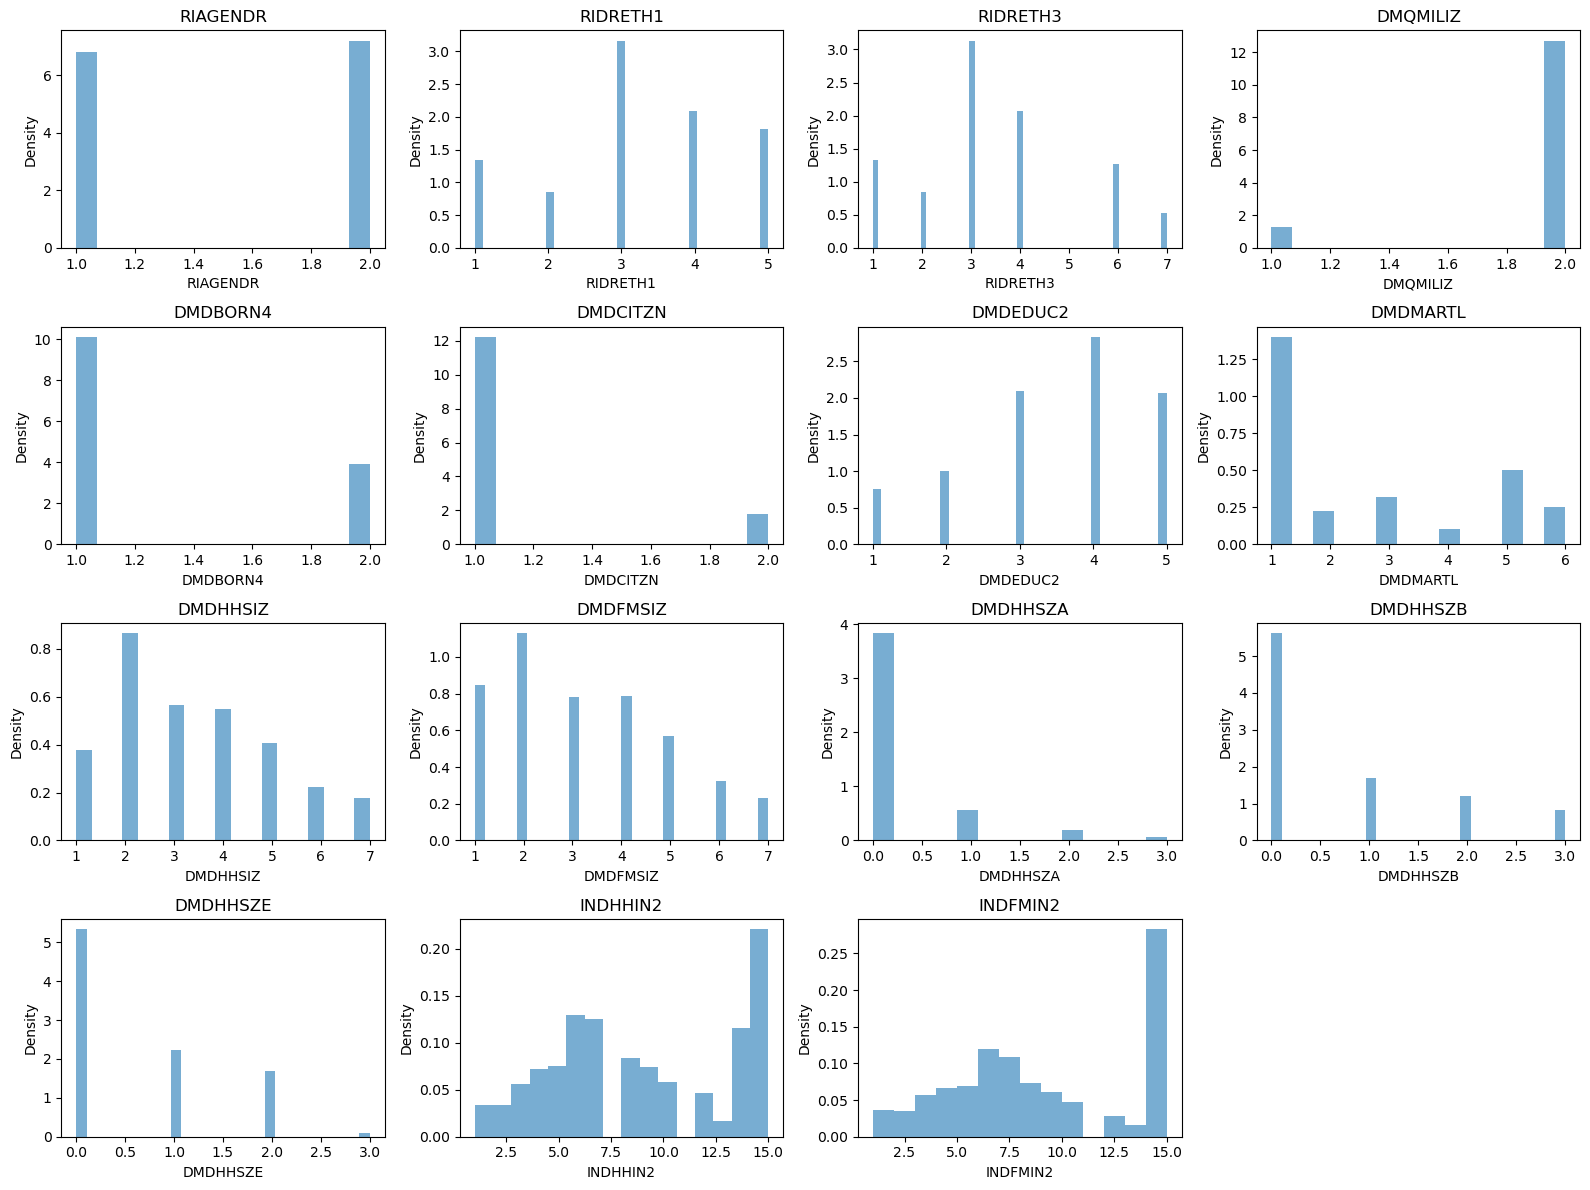

In [186]:
# Plotting Distributions of categorical data

# Define grid size
n_cols = 4  # Number of histograms per row
n_rows = math.ceil(len(df[categorical_vars].columns) / n_cols)


# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(df[categorical_vars].columns):
    data = df[categorical_vars][col].dropna()
    
    # Histogram
    axes[i].hist(data, bins='auto', density=True, alpha=0.6)
    
    # Fit normal distribution
    mu, sigma = norm.fit(data)
    
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Density")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [187]:
# Print normalized value counts for each categorical variable
for col in categorical_vars:
    print(f"Variable: {col}")
    counts = df[col].value_counts(normalize=True, dropna=False).sort_index()
    for val, pct in counts.items():
        print(f"  Class {val}: {pct:.2%}")
    print()

Variable: RIAGENDR
  Class 1.0: 48.54%
  Class 2.0: 51.46%

Variable: RIDRETH1
  Class 1.0: 14.49%
  Class 2.0: 9.21%
  Class 3.0: 34.18%
  Class 4.0: 22.58%
  Class 5.0: 19.54%

Variable: RIDRETH3
  Class 1.0: 14.49%
  Class 2.0: 9.21%
  Class 3.0: 34.18%
  Class 4.0: 22.58%
  Class 6.0: 13.83%
  Class 7.0: 5.71%

Variable: DMQMILIZ
  Class 1.0: 8.30%
  Class 2.0: 80.96%
  Class nan: 10.74%

Variable: DMDBORN4
  Class 1.0: 72.16%
  Class 2.0: 27.79%
  Class nan: 0.05%

Variable: DMDCITZN
  Class 1.0: 87.01%
  Class 2.0: 12.62%
  Class nan: 0.36%

Variable: DMDEDUC2
  Class 1.0: 7.11%
  Class 2.0: 9.46%
  Class 3.0: 19.78%
  Class 4.0: 26.83%
  Class 5.0: 19.64%
  Class nan: 17.17%

Variable: DMDMARTL
  Class 1.0: 41.49%
  Class 2.0: 6.73%
  Class 3.0: 9.45%
  Class 4.0: 3.01%
  Class 5.0: 14.81%
  Class 6.0: 7.44%
  Class nan: 17.07%

Variable: DMDHHSIZ
  Class 1: 11.94%
  Class 2: 27.34%
  Class 3: 17.85%
  Class 4: 17.37%
  Class 5: 12.89%
  Class 6: 7.00%
  Class 7: 5.61%

Variable

## Target Analysis

Our target variable is `LBXGH` (glycohemoglobin, or HbA1c level).
This section explores:
- The distribution of HbA1c in the sample.
- Relationships between `LBXGH` and selected numerical and categorical predictors.

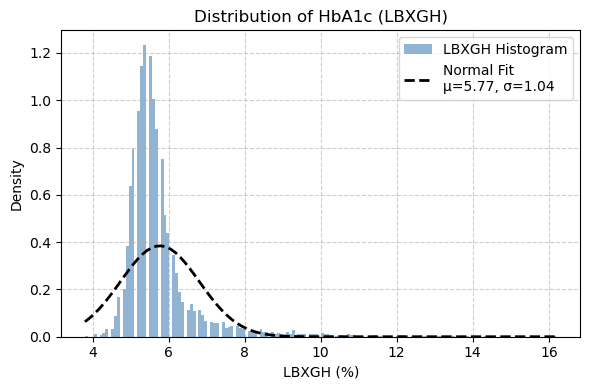

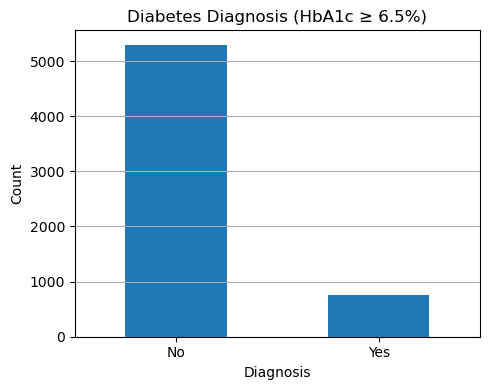

In [ ]:
# Fit normal distribution to LBXGH
mu, sigma = norm.fit(df['LBXGH'].dropna())

# Crea# Plot histogram and fitted PDF
plt.figure(figsize=(6, 4))
count, bins, _ = plt.hist(
    df['LBXGH'].dropna(),
    bins='auto',
    density=True,
    alpha=0.6,
    color='steelblue',
    label='LBXGH Histogram'
)

# Plot the fitted normal distribution
x = np.linspace(bins[0], bins[-1], 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k--', linewidth=2, label=f'Normal Fit\nμ={mu:.2f}, σ={sigma:.2f}')

# Final plot
plt.title("Distribution of HbA1c (LBXGH)")
plt.xlabel("LBXGH (%)")
plt.ylabel("Density")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

df['Diagnosis'] = (df['LBXGH'] >= 6.5)

df["Diagnosis"].value_counts().sort_index().plot(
    kind="bar", 
    rot=0, 
    figsize=(5, 4), 
    title="Diabetes Diagnosis (HbA1c ≥ 6.5%)"
)
plt.xticks(ticks=[0, 1], labels=["No", "Yes"])
plt.ylabel("Count")
plt.xlabel("Diagnosis")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()



### Relationship Between Features and Target (LBXGH)

To assess predictive strength, we visualize how each feature relates to `LBXGH`:

- For **numerical variables**, we use scatterplots with optional smoothing.
- For **categorical variables**, we use boxplots grouped by category.

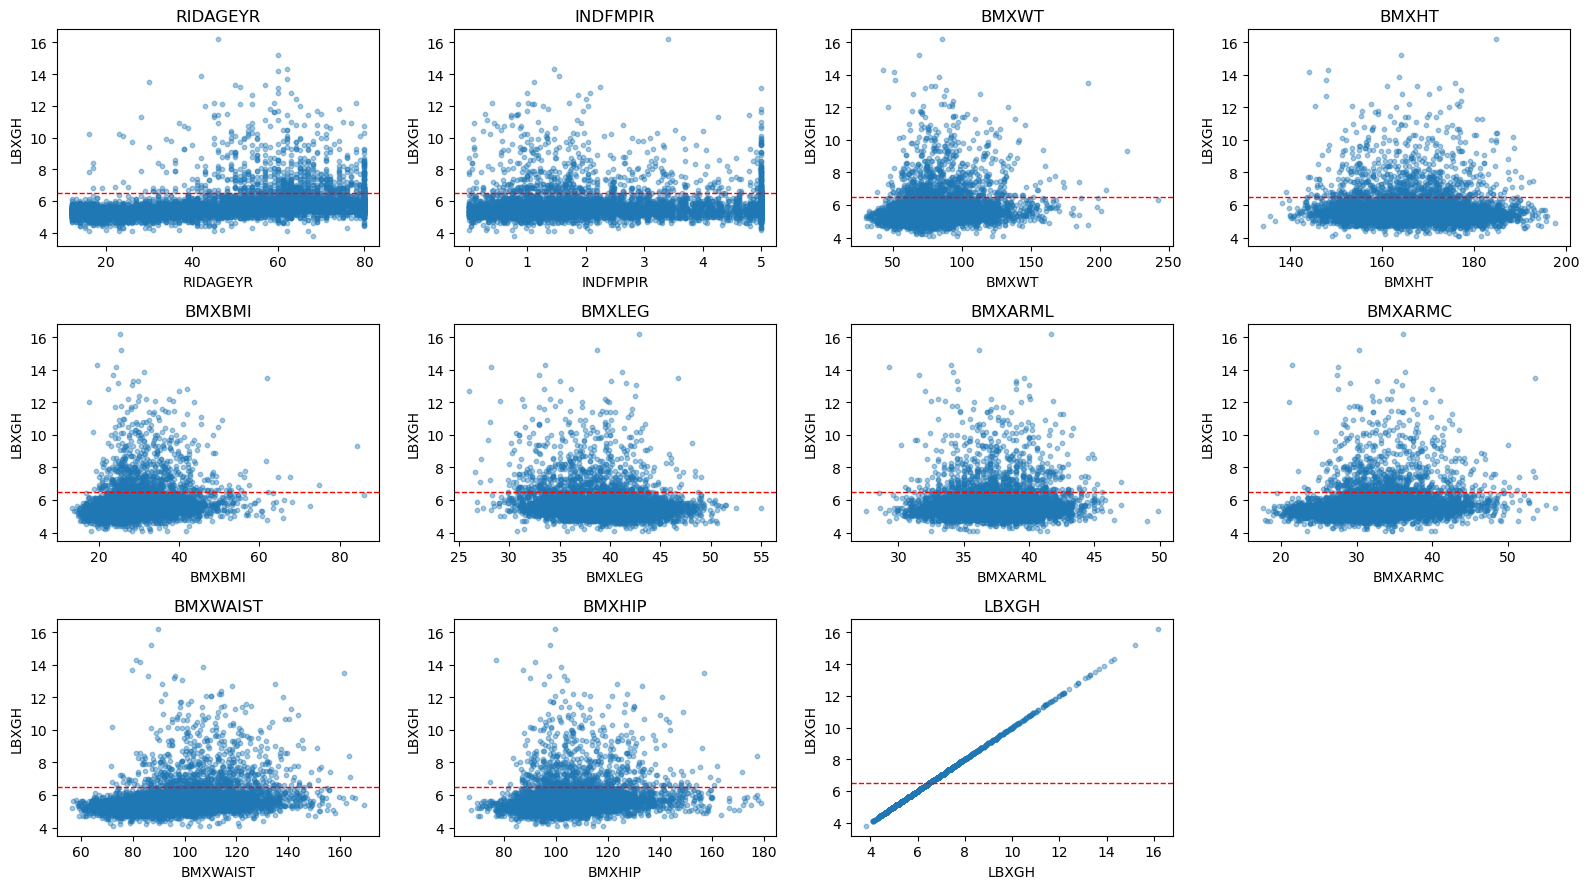

In [204]:
# Scatterplots: LBXGH vs numeric features (compact layout)
n_cols = 4
n_rows = math.ceil(len(numeric_vars) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(numeric_vars):
    x = df[col].dropna()
    y = df["LBXGH"].loc[x.index]
    axes[i].scatter(x, y, alpha=0.4, s=10)
    
    # Add horizontal line at HbA1c = 6.5 (diabetes threshold)
    axes[i].axhline(6.5, color='red', linestyle='--', linewidth=1)
    
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("LBXGH")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



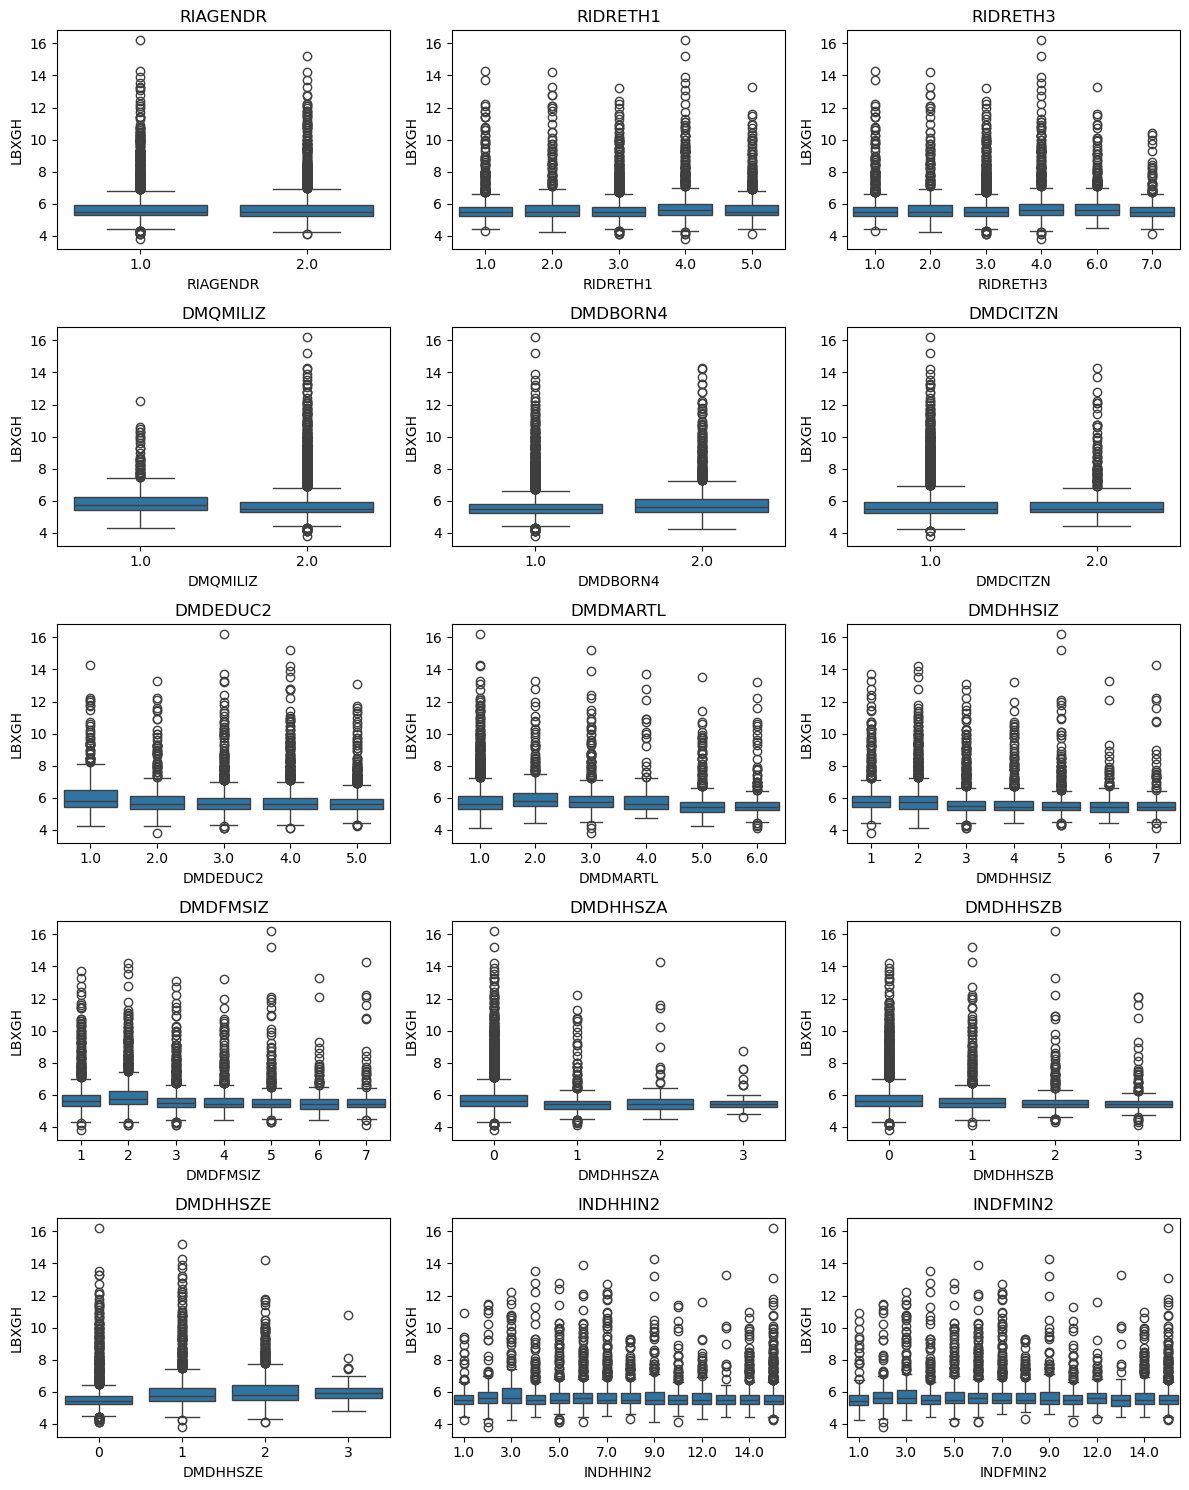

In [191]:
import matplotlib.ticker as ticker

# Categorical vars should still be cast to category
df_clean = df.copy()
categorical_clean = []

for col in categorical_vars:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype("category")
        categorical_clean.append(col)

# Boxplot layout
n_cols = 3
n_rows = math.ceil(len(categorical_clean) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(categorical_clean):
    try:
        sns.boxplot(x=df_clean[col], y=df_clean["LBXGH"], ax=axes[i])
        axes[i].set_title(f"{col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("LBXGH")

        # Force integer ticks if axis is numeric (like 0–5)
        axes[i].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    except Exception:
        fig.delaxes(axes[i])

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



### Target Correlation Analysis

We now explore how `LBXGH` varies across:
- Binned numerical variables (e.g., age)
- Categorical variables (e.g., education, ethnicity, income)

#### Numerical

In [205]:
# Finding Absolute Correlation with target var from Numerical Vars

correlationsp = df[numeric_vars].corrwith(df["LBXGH"], method='pearson')
correlationsp = abs(correlationsp).sort_values(ascending=False)

correlationsk = df[numeric_vars].corrwith(df["LBXGH"], method='kendall')
correlationsk = abs(correlationsk.sort_values(ascending=False))

correlationss = df[numeric_vars].corrwith(df["LBXGH"], method='spearman')
correlationss = abs(correlationss.sort_values(ascending=False))

correlationsk


LBXGH       1.000000
RIDAGEYR    0.353803
BMXWAIST    0.252921
BMXBMI      0.202989
BMXWT       0.162078
BMXHIP      0.155613
BMXARMC     0.154569
BMXARML     0.054266
INDFMPIR    0.017448
BMXHT       0.029238
BMXLEG      0.115177
dtype: float64

#### Categorical

In [206]:
# Running one-way anova on categorical vars

from scipy.stats import f_oneway

for var in categorical_vars:
    groups = [df[df[var] == level]["LBXGH"].dropna() for level in df[var].dropna().unique()]
    try:
        f_stat, p_val = f_oneway(*groups)
        print(f"{var}: F = {f_stat:.4f}, p = {p_val:.4g}")
    except ValueError:
        print(f"{var}: Skipped (not enough data or levels)")


RIAGENDR: F = 5.6362, p = 0.01762
RIDRETH1: F = 10.4093, p = 2.116e-08
RIDRETH3: F = 8.8699, p = 2.111e-08
DMQMILIZ: F = 18.1168, p = 2.113e-05
DMDBORN4: F = 68.9807, p = 1.216e-16
DMDCITZN: F = 3.1079, p = 0.07796
DMDEDUC2: F = 17.3210, p = 4.023e-14
DMDMARTL: F = 28.7875, p = 6.889e-29
DMDHHSIZ: F = 23.5828, p = 1.047e-27
DMDFMSIZ: F = 21.8105, p = 1.632e-25
DMDHHSZA: F = 27.1179, p = 2.05e-17
DMDHHSZB: F = 43.5364, p = 7.933e-28
DMDHHSZE: F = 128.1999, p = 1.653e-80
INDHHIN2: F = 3.0017, p = 0.0002057
INDFMIN2: F = 2.7732, p = 0.0005998


In [194]:
from itertools import combinations
from statsmodels.formula.api import ols


print("\n Two-Way ANOVA (All Pairs):\n")
for var1, var2 in combinations(categorical_vars, 2):
    try:
        formula = f"LBXGH ~ C({var1}) + C({var2}) + C({var1}):C({var2})"
        model = ols(formula, data=df).fit()
        table = sm.stats.anova_lm(model, typ=3)
        interaction_p = table.loc[f"C({var1}):C({var2})", "PR(>F)"]
        print(f"{var1:10s} × {var2:10s} | Interaction p = {interaction_p:.4g}")
    except Exception as e:
        print(f"{var1:10s} × {var2:10s} | ERROR: {e}")


 Two-Way ANOVA (All Pairs):

RIAGENDR   × RIDRETH1   | Interaction p = 0.05123
RIAGENDR   × RIDRETH3   | Interaction p = 0.05022
RIAGENDR   × DMQMILIZ   | Interaction p = 0.1534
RIAGENDR   × DMDBORN4   | Interaction p = 0.6138
RIAGENDR   × DMDCITZN   | Interaction p = 0.1812
RIAGENDR   × DMDEDUC2   | Interaction p = 0.1695
RIAGENDR   × DMDMARTL   | Interaction p = 0.5851
RIAGENDR   × DMDHHSIZ   | Interaction p = 0.07294
RIAGENDR   × DMDFMSIZ   | Interaction p = 0.06588
RIAGENDR   × DMDHHSZA   | Interaction p = 0.4618
RIAGENDR   × DMDHHSZB   | Interaction p = 0.5938
RIAGENDR   × DMDHHSZE   | Interaction p = 0.4829
RIAGENDR   × INDHHIN2   | Interaction p = 0.006557
RIAGENDR   × INDFMIN2   | Interaction p = 0.02535
RIDRETH1   × RIDRETH3   | Interaction p = 1.071e-07
RIDRETH1   × DMQMILIZ   | Interaction p = 0.3631
RIDRETH1   × DMDBORN4   | Interaction p = 0.0007949
RIDRETH1   × DMDCITZN   | Interaction p = 1.162e-05
RIDRETH1   × DMDEDUC2   | Interaction p = 0.02262
RIDRETH1   × DMDMARTL 

## Imputation & Encoding

To prepare data for modeling, we first:
- **Encode categorical features** numerically.
- **Impute missing values** in both categorical and numeric features.

This ensures all model inputs are numeric and no missing values are left behind.


### 1. Encoding Categorical Features

We use ordinal and one-hot encoding for categorical variables.

In [207]:
# Binary mappings
df["RIAGENDR_bin"]   = df["RIAGENDR"].map({1: 0, 2: 1})
df["DMQMILIZ_bin"]   = df["DMQMILIZ"].map({1: 1, 2: 0})
df["DMDBORN4_bin"]   = df["DMDBORN4"].map({1: 1, 2: 0})
df["DMDCITZN_bin"]   = df["DMDCITZN"].map({1: 1, 2: 1, 3: 0})  # Citizens (by birth or naturalized) = 1

# One-hot encoding for remaining categorical vars
one_hot_vars = ["RIDRETH1", "RIDRETH3", "DMDEDUC2", "DMDMARTL"]
df_onehot = pd.get_dummies(df[one_hot_vars], columns=one_hot_vars, dummy_na=True, prefix=one_hot_vars)

# Combine all encoded features
encoded_df = pd.concat([
    df[["RIAGENDR_bin", "DMQMILIZ_bin", "DMDBORN4_bin", "DMDCITZN_bin"]],
    df_onehot
], axis=1)

### 2. Imputing Missing Values

We fill in missing values using:
- **Numerical:** median imputation (robust to outliers)
- **Categorical:** mode imputation (most frequent category)


In [211]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
import pandas as pd
import numpy as np

# 1. Standardize numerical features
scaler = StandardScaler()
scaled_numeric_df = pd.DataFrame(
    scaler.fit_transform(df[numeric_vars]),
    columns=numeric_vars,
    index=df.index
)

# 2. Combine with encoded categorical features
final_df = pd.concat([scaled_numeric_df, encoded_df], axis=1)

# 3. Impute using IterativeImputer
imputer = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=200,
    tol=1e-3,
    random_state=0,
    verbose=2,
    skip_complete=True
)
imputed_array = imputer.fit_transform(final_df)
imputed_df = pd.DataFrame(imputed_array, columns=final_df.columns, index=final_df.index)

# 4. Unscale numeric features
unscaled_numeric = pd.DataFrame(
    scaler.inverse_transform(imputed_df[numeric_vars]),
    columns=numeric_vars,
    index=imputed_df.index
)

# 5. Keep imputed categorical features
imputed_cat = imputed_df.drop(columns=numeric_vars)

# 6. Combine to get final cleaned dataframe
cleaned_df = pd.concat([unscaled_numeric, imputed_cat], axis=1)

# 7. Identify binary columns and round
binary_cols = [col for col in encoded_df.columns if set(cleaned_df[col].dropna().unique()).issubset({0, 1})]

# 8. Round and clip binary columns
cleaned_df[binary_cols] = cleaned_df[binary_cols].round().clip(0, 1)

[IterativeImputer] Completing matrix with shape (6045, 41)
[IterativeImputer] Ending imputation round 1/200, elapsed time 0.31
[IterativeImputer] Change: 21.40064975731503, scaled tolerance: 0.010050991549250356 
[IterativeImputer] Ending imputation round 2/200, elapsed time 0.40
[IterativeImputer] Change: 4.061620388299687, scaled tolerance: 0.010050991549250356 
[IterativeImputer] Ending imputation round 3/200, elapsed time 0.48
[IterativeImputer] Change: 1.8854422963402968, scaled tolerance: 0.010050991549250356 
[IterativeImputer] Ending imputation round 4/200, elapsed time 0.57
[IterativeImputer] Change: 1.2029721338929065, scaled tolerance: 0.010050991549250356 
[IterativeImputer] Ending imputation round 5/200, elapsed time 0.65
[IterativeImputer] Change: 0.7181328101839666, scaled tolerance: 0.010050991549250356 
[IterativeImputer] Ending imputation round 6/200, elapsed time 0.76
[IterativeImputer] Change: 0.5526813771200281, scaled tolerance: 0.010050991549250356 
[IterativeImp

In [216]:
df_o = df_o.reset_index(drop=True)
cleaned_df = cleaned_df.reset_index(drop=True)

cleaned_df['LBXGH'] = df_o['LBXGH']

cleaned_df.to_csv("datasets/cleaned_data.csv", index=False)

cleaned_df


,RIDAGEYR,INDFMPIR,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,BMXHIP,...,DMDEDUC2_4.0,DMDEDUC2_5.0,DMDEDUC2_nan,DMDMARTL_1.0,DMDMARTL_2.0,DMDMARTL_3.0,DMDMARTL_4.0,DMDMARTL_5.0,DMDMARTL_6.0,DMDMARTL_nan
0,66.0,0.820000,79.5,158.3,31.7,37.0,36.0,32.0,101.8,110.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,18.0,2.831865,66.3,175.7,21.5,46.6,38.8,27.0,79.3,94.4,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,13.0,1.880000,45.4,158.4,18.1,38.1,33.8,21.5,64.1,83.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,66.0,1.630000,53.5,150.2,23.7,31.8,30.6,27.4,88.2,90.1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,75.0,0.410000,88.8,151.1,38.9,31.9,36.0,38.1,113.0,131.3,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,70.0,0.950000,49.0,156.5,20.0,34.4,32.6,25.1,82.2,87.3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6041,42.0,1.391422,97.4,164.9,35.8,38.2,36.6,40.6,114.8,112.8,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6042,41.0,1.180000,69.1,162.6,26.1,39.2,35.2,26.8,86.4,102.7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6043,14.0,2.240000,111.9,156.6,45.6,39.2,35.0,44.5,113.5,128.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Notes: